In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import cv2 as cv
import pickle

In [21]:
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Load from the pickle file
with open('data/train/processed/SIFT_data.pkl', 'rb') as file:
    sift_data = pickle.load(file)

# Load from the pickle file
with open('data/train/processed/resized_data.pkl', 'rb') as file:
    raw_data = pickle.load(file)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sift, Y, test_size=0.25, random_state=42)

In [19]:
# Here's an example of one image (sift keypoints and descriptors)

print("\nThe 1st keypoint:")
print(x_train[0][0][0])
print("\nThe 1st descriptor:")
print(x_train[0][1][0])

print("\nThe 2nd keypoint:")
print(x_train[1][0][0])
print("\nThe 2nd descriptor:")
print(x_train[1][1][0])


The 1st keypoint:
< cv2.KeyPoint 0x178679710>

The 1st descriptor:
[ 28.   0.   0.   0.   0.   0.   0.   2. 187.  12.   1.   0.   0.   0.
   0.  15. 127.  57.  29.   0.   0.   0.   0.   2.  19.  59.   8.   5.
   8.   1.   0.   1.  45.   0.   0.   0.   0.   0.   0.   2. 187.  13.
   0.   0.   0.   0.   1.  28. 122.  33.  11.   3.  10.  16.  14.  16.
   5.  65.  82.  25.  16.   4.   1.   0.  49.   0.   0.   0.   0.   0.
   0.   4. 187.  38.   0.   0.   0.   0.   0.  36. 117.  68.   3.   4.
  37.  15.   3.  11.   1.   7.  39.  34. 125.  43.   1.   0.  52.   0.
   0.   0.   0.   0.   0.   5. 187.   3.   0.   0.   0.   0.   0.  44.
  73.  27.   1.   0.   7.   3.   1.  13.   5.  10.   1.   1.  48.  76.
  17.   1.]

The 2nd keypoint:
< cv2.KeyPoint 0x178ae7180>

The 2nd descriptor:
[ 34.   0.   0.   0.   0.   0.   0.   3. 192.   5.   0.   0.   0.   0.
   0.  43. 140.  26.   0.   0.   0.   3.   7.  18.   7.  15.   4.   1.
   5.  22.  17.   2.  58.   0.   0.   0.   0.   0.   0.   4. 192.   5.


In [10]:
def calculate_conv_shape(X, K, padding=0, stride=1):
    """Calculate the shape of the output of a convolution 
    
    Args:
        X (np.array): The input matrix
        K (np.array): The filter matrix
        padding (int, optional): Defaults to 0. The padding dimension
        stride (int, optional): Defaults to 1. The stride of the convolution
    
    Returns:
        tuple: The shape of the convolution output, height then width
    """
    L_padded = len(X[0]) + 2*padding
    H_padded = len(X) + 2*padding

    L_kernel = len(K[0])
    H_kernel = len(K)

    return (int((H_padded - H_kernel)/stride + 1), int((L_padded - L_kernel)/stride + 1))

In [11]:
# Here, we define a "blurring" filter/kernel, that can be applied
# to an image to get a blurred output image.

blur = np.array([
    [0,    0.25, 0   ],
    [0.25, 0.5,  0.25],
    [0,    0.25, 0   ]
])

# If we pad our 28x28 example image and then convolve it
# with the blurring kernel (with stride=1), the output
# image should also be 28x28.
calculate_conv_shape(example, blur, padding=1)

(28, 28)

In [12]:
ans = calculate_conv_shape(example, blur, padding=1)
assert isinstance(ans, tuple)
assert isinstance(ans[0], int)
assert isinstance(ans[1], int)
assert ans == (28, 28)
ans = calculate_conv_shape(example, blur, padding=0, stride=2)
assert ans == (13, 13)

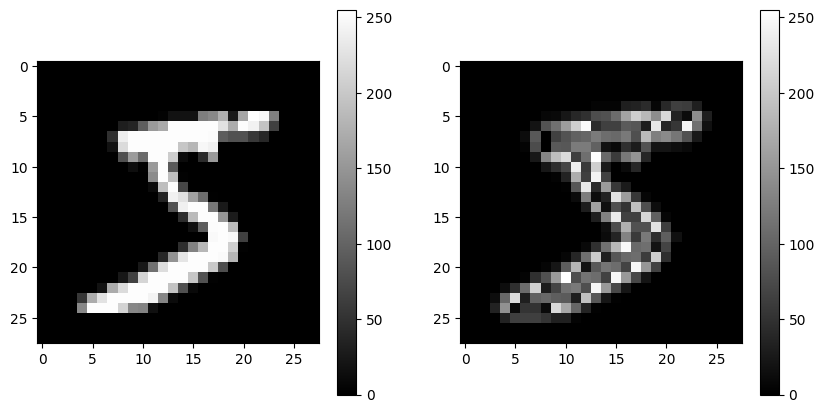

In [13]:
# Apply the blurring filter to the example and save the output to "blurred_image".
#
# Be sure to convert the example from unsigned int numbers to floating-point numbers
# beforehand.

blurred_image = scipy.ndimage.convolve(
    example,
    blur
    )

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example, cmap="gray")
plt.colorbar()
           
plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap="gray")
_ = plt.colorbar()

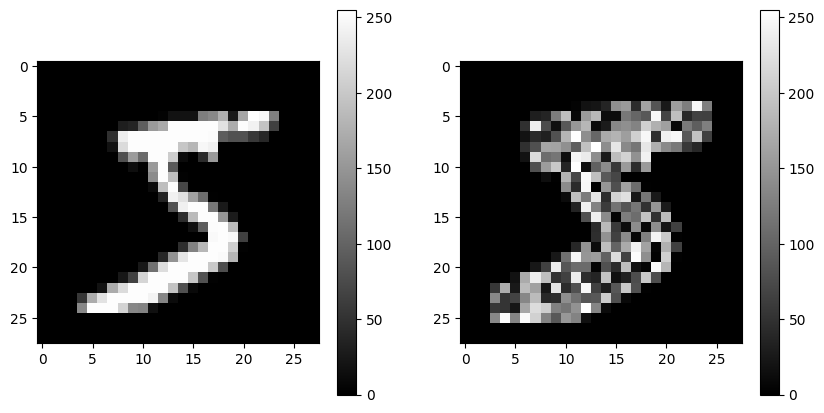

In [14]:
# Create a 3x3 filter of your choice (a matrix of numbers) and save it as "my_filter".
#
# Then apply that filter to the example and save the output image as "filtered_image".
#
# Again, be sure to convert the example from unsigned int numbers to floating-point
# numbers beforehand.

my_filter = np.array([[1, 0, 1],
             [0, 1, 0],
             [1, 0, 1]])

filtered_image = scipy.ndimage.convolve(
    example,
    my_filter
    )

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example, cmap="gray")
plt.colorbar()
           
plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap="gray")
_ = plt.colorbar()

In [17]:
# Now you'll build a CNN that has the same number of layers as the
# feedforward NN, and a comparable number of model parameters.
#
# The CNN's convolutional and pooling layers will steadily reduce the
# number of neurons/outputs in the vertical and horizontal dimensions
# while increasing the number of channels (the "depth" dimension).
#
# Your CNN model should be defined by a list of layers, called "cnn_layers",
# organized as such:
# [Input(),
#  Conv2D(),
#  MaxPool2D(),
#  Conv2D(),
#  MaxPool2D(),
#  Flatten(),
#  Dense()]
#
# Create that list such that the first and second Conv2D layers have 16 and
# 32 channels, respectively. Use a (3, 3)-shaped convolutional kernel
# for both Conv2D layers, along with "same" padding and "relu" activation.
#
# You can use the defaults for the MaxPool2D layers (pooling over a 2x2
# area, which thus halves the width and height dimensions).
#
# You'll then flatten the output of the second/last pooling layer, and
# send that to a Dense output layer of 10 neurons. Be sure to use the
# appropriate activation function for the output layer, as you did for
# the feedforward NN.
#
# Dropout doesn't provide much regularization support in CNN models, as
# the constraints imposed by architecture itself provides that. So we
# won't use Dropout layers in the CNN.

# Create your CNN model using Sequential, and save it as "cnn_model".

from tensorflow.keras.layers import Conv2D, MaxPool2D

cnn_layers = []
cnn_layers.append(keras.layers.Input(shape=(28, 28, 1)))
cnn_layers.append(keras.layers.Conv2D(16, 3, activation='relu'))
cnn_layers.append(keras.layers.MaxPool2D())
cnn_layers.append(keras.layers.Conv2D(32, 3, activation='relu'))
cnn_layers.append(keras.layers.MaxPool2D())
cnn_layers.append(keras.layers.Flatten())
cnn_layers.append(keras.layers.Dense(10, activation='softmax'))


cnn_model = keras.Sequential(cnn_layers)


cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8407 - loss: 2.4122 - val_accuracy: 0.9689 - val_loss: 0.1278
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9713 - loss: 0.1091 - val_accuracy: 0.9755 - val_loss: 0.0972
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9797 - loss: 0.0708 - val_accuracy: 0.9802 - val_loss: 0.0736

Accuracy on the final epoch of training was 98.05%


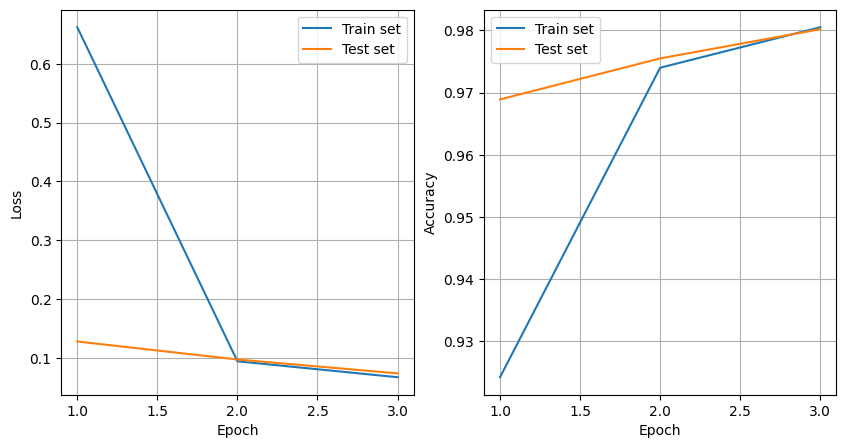

In [18]:
# Now we'll train the CNN model.
#
# Because the 2D architecture of the CNN constrains the model to learn patterns
# that exist in 2D space (e.g., nearby pixels are more likely to exhibit some
# connectedness/pattern than distant pixles) the model learns much more quickly
# (that is, with fewer training epochs). So we'll only train for 3 epochs this time.
# You can increase the number of epochs if you'd like.
#
# Also, the model expects the input samples to have a "channel" dimension, e.g.,
# three channels (red/green/blue) for color images, 1 channel for grayscale images.
# So we'll reshape our training images from (n_samples, 28, 28) to
# (n_samples, 28, 28, 1).
#
# Note that we used 'sparse_categorical_crossentropy' as the loss function,
# which is typical for classification tasks with a softmax output activation function.

cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
n_epochs = 3
history = cnn_model.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=n_epochs,
                        validation_data=(x_test.reshape(-1, 28, 28 ,1), y_test))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_loss'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs+1), history.history['accuracy'], label='Train set')
plt.plot(np.arange(1, n_epochs+1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
print(f"\nAccuracy on the final epoch of training was {100*history.history['accuracy'][-1]:0.2f}%")

In [19]:
# Let's assess our CNN model's performance on the test set
cnn_scores = cnn_model.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)

print(f"\nThe CNN model achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9744 - loss: 0.0950

The CNN model achieves an accuracy of 98.02% on the test data.
